<a href="https://colab.research.google.com/github/yuhui-0611/contest/blob/main/Poverty_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

< Poverty Prediction Challenge >

- 주최: World Bank (세계은행) & DrivenData

- 목표: 제한된 설문(survey) 데이터를 활용하여 각각의 가구별 1인당 일일 소비량 (per-capita consumption)을 예측하고 이를 기반으로 인구 수준의 빈곤율 (poverty rate) 을 다양한 기준(threshold)으로 예측하는 모델 개발

< 실제 세계은행 연구자들이 직면하는 문제 >

✔ 오래된 설문조사에는 자세한 소비 데이터가 있지만

✔ 최근 설문에는 그 정보가 없을 때가 많음

- 이럴 경우 새로운 설문에서 소비량을 직접적으로 측정할 수 없기 때문에
- 머신러닝 모델을 활용해 이를 보간(imputation) 해야 함

> 즉: 과거 잘-레이블된 설문 → 새로운 설문 예측으로 소비량과 빈곤율 추정

< 데이터 구조 >

훈련(train) 데이터

- 여러 연도의 가구 설문 응답
- 각 가구의 1인당 일일 소비량(ground truth)
- 인구 가중치(weights)
- 설문 항목: 인구학, 교육, 주거, 식품 소비, 지리 등

테스트(test) 데이터

- 소비량/빈곤율 라벨 없음
- 기존 모델로 예측해야 함

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

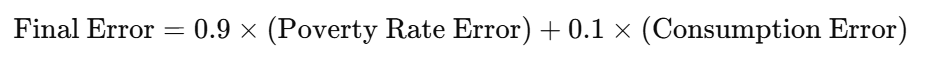

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA

X : Household survey features → 설명 변수

y₁ : Household consumption labels → 1인당 하루 소비액 (USD/day)

y₂ : Survey-level poverty rate labels → 설문 전체 빈곤율 (여러 빈곤선 threshold)

< 전체 순서 >

```
X + y1  → 가구 소비 모델 학습
예측된 소비 → 빈곤율 계산
계산된 빈곤율 ↔ y2 비교 (검증)
```



In [4]:
X = pd.read_csv('/content/drive/MyDrive/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/contest/train_rates_gt.csv')

In [18]:
test = pd.read_csv('/content/drive/MyDrive/contest/test_hh_features.csv')

In [5]:
X.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


In [6]:
y1.head()

,survey_id,hhid,cons_ppp17
0,100000,100001,25.258402
1,100000,100002,16.996706
2,100000,100003,13.671848
3,100000,100004,7.189475
4,100000,100005,12.308855


In [7]:
y2.head()

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
1,200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
2,300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


In [19]:
test.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,400001,1,320,4,567.80914,Female,4,0,1,0,...,No,No,No,No,No,Yes,Yes,Yes,No,400000
1,400002,1,480,4,561.70367,Female,6,0,1,1,...,Yes,No,No,No,No,Yes,Yes,Yes,No,400000
2,400003,1,320,4,183.16423,Male,4,0,0,0,...,Yes,No,Yes,No,Yes,Yes,No,Yes,No,400000
3,400004,1,320,4,696.02411,Male,4,0,0,1,...,Yes,Yes,No,No,No,Yes,Yes,No,No,400000
4,400005,1,320,4,286.95731,Male,4,0,0,1,...,Yes,No,No,No,No,No,Yes,No,No,400000


# Processing

< 전처리 순서 >


```
X, y1 merge
split
X / y 분리
결측치 처리 fit, transform
```



## X, y1 merge

In [8]:
train = X.merge(
    y1,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)

In [9]:
train.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [13]:
train.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

| 컬럼          | 의미         |
| ----------- | ---------- |
| `hhid`      | 가구 ID      |
| `survey_id` | 설문 ID      |
| `com`       | 가구원 식별용 코드 |
| `weight`    | 표본 가중치     |
| `strata`    | 층화 표본 변수   |
| ------------------------- | --------- |
| `hsize`                   | 가구원 수     |
| `num_children5/10/18`     | 연령대별 아동 수 |
| `num_adult_male / female` | 성인 남/여 수  |
| `num_elderly`             | 고령자 수     |
| `age`                     | 가구주 연령    |
| `male`                    | 가구주 성별    |
| ----------------------------- | -------- |
| `owner`                       | 주택 소유 여부 |
| `dweltyp`                     | 주거 형태    |
| `water`, `water_source`       | 물 공급     |
| `toilet`, `sanitation_source` | 위생 시설    |
| `sewer`, `elect`              | 하수/전기    |
| ------------------------------ | ----------- |
| `employed`                     | 고용 여부       |
| `sworkership`                  | 고용 형태       |
| `share_secondary`              | 2차 산업 종사 비율 |
| `educ_max`                     | 최고 학력       |
| `sector1d`                     | 산업 분류       |
| `fsworkership`, `any_nonagric` | 직업 특성       |
| `urban`                        | 도시/농촌       |
| `region1~7`                    | 지역 더미       |
| ------------------------------ | -------------------- |
| `consumed100` ~ `consumed5000` | 특정 품목 소비 여부 (Yes/No) |
| ------------------------------ | -------------------- |
| `cons_ppp17` | **1인당 하루 소비액 (정답 y1)** |


## split

- train_test_split을 쓰려면, 각 행이 서로 독립이고 아무 행이나 섞어도 괜찮아야 함
- 하지만, 같은 survey_id 안에 있는 여러 행(가구)들이 여러 열 값 전반에서 서로 유사함
- 즉, 같은 group에 속한 행들은 train과 validation에 동시에 존재하지 않도록 같은 쪽으로 split되어야 함

In [14]:
from sklearn.model_selection import GroupShuffleSplit

In [15]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

## X / y 분리

In [17]:
ID_COLS = ["survey_id", "hhid"]
TARGET = "cons_ppp17"

X_tr_raw  = train_df.drop(columns=ID_COLS + [TARGET]).copy()
y_tr      = train_df[TARGET].copy()

X_val_raw = val_df.drop(columns=ID_COLS + [TARGET]).copy()
y_val     = val_df[TARGET].copy()

## test data set

In [21]:
test_id = test[ID_COLS].copy()
X_test_raw = test.drop(columns=ID_COLS).copy()

# train에서 만든 X_tr_raw랑 컬럼이 완전히 같은 순서/구성이어야 안전
X_test_raw = X_test_raw.reindex(columns=X_tr_raw.columns)

## 결측치 처리 fit, transform

In [23]:
na_cnt_tr = X_tr_raw.isna().sum()
na_cnt_tr = na_cnt_tr[na_cnt_tr > 0].sort_values(ascending=False)
na_cnt_tr

,0
sector1d,9876
dweltyp,822
utl_exp_ppp17,85
consumed5000,43
consumed4600,35
consumed4900,35
consumed4800,35
consumed4500,34
consumed4400,32
consumed4300,31


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed

In [24]:
na_cnt_val = X_val_raw.isna().sum()
na_cnt_val = na_cnt_val[na_cnt_val > 0].sort_values(ascending=False)
na_cnt_val

,0
sector1d,4253
dweltyp,384
consumed5000,23
consumed4900,21
consumed4800,21
consumed4700,21
consumed4600,21
consumed4300,21
consumed4500,20
consumed4400,20


- sector1d
- dweltyp
- employed
- share_secondary
- educ_max
- consumed

In [25]:
na_cnt_test = X_test_raw.isna().sum()
na_cnt_test = na_cnt_test[na_cnt_test > 0].sort_values(ascending=False)
na_cnt_test

,0
sector1d,15589
dweltyp,1122
utl_exp_ppp17,283
consumed5000,104
consumed4900,88
consumed4400,86
consumed4600,79
consumed4800,77
consumed4700,77
consumed4500,76


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed